In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [31]:
import tensorflow as tf
from tensorflow.config import experimental as tf_exp
physical_devices = tf_exp.list_physical_devices('GPU')
print(physical_devices)
for gpu in physical_devices:
    tf_exp.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [32]:
weatherAUS = pd.read_csv('weatherAUS.csv')
len(weatherAUS)

145460

NaN dans Temp9am: 1767
NaN dans Temp3pm: 3609
NaN dans la colonne de sortie: 1129
NaN dans Humidity9am: 2654
NaN dans Humidity3pm: 4507
NaN dans la colonne de sortie: 1887
NaN dans WindSpeed9am: 1767
NaN dans WindSpeed3pm: 3062
NaN dans la colonne de sortie: 1213
NaN dans Pressure9am: 15065
NaN dans Pressure3pm: 15028
NaN dans la colonne de sortie: 14804


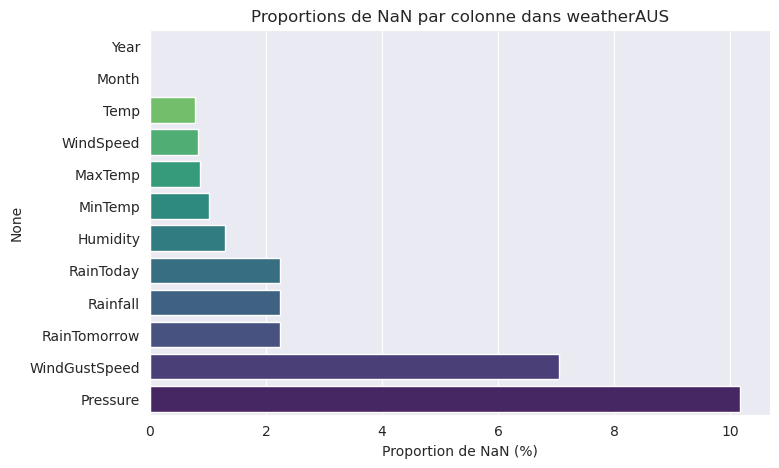

In [33]:
def combine_values(df, column1, column2, verbose=False):
    result = pd.Series(index=df.index)

    for i, row in df.iterrows():
        if pd.isna(row[column1]) and pd.isna(row[column2]):
            result[i] = np.nan
        elif pd.isna(row[column1]):
            result[i] = row[column2]
        elif pd.isna(row[column2]):
            result[i] = row[column1]
        else:
            result[i] = (row[column1] + row[column2]) / 2
    if verbose:
        # Afficher le nombre de NaN dans les colonnes d'entrée et la colonne de sortie
        num_nan_input1 = df[column1].isna().sum()
        num_nan_input2 = df[column2].isna().sum()
        num_nan_output = result.isna().sum()
        print(f"NaN dans {column1}: {num_nan_input1}")
        print(f"NaN dans {column2}: {num_nan_input2}")
        print(f"NaN dans la colonne de sortie: {num_nan_output}")

    return result

def display_nan_proportion(dataframe: pd.DataFrame, dataframe_name: str = "le dataframe"):
    nan_proportions = (dataframe.isna().sum() / len(dataframe)) * 100
    nan_proportions = nan_proportions.sort_values(ascending=False)

    plt.figure(figsize=(8, 5))
    sns.barplot(x=nan_proportions.values, y=nan_proportions.index, hue=nan_proportions.index, palette='viridis', legend=False)
    plt.xlabel('Proportion de NaN (%)')
    plt.title(f'Proportions de NaN par colonne dans {dataframe_name}')
    plt.gca().invert_yaxis()  # La colonne avec le plus de NaN en bas
    plt.show()

weatherAUS['Temp'] = combine_values(weatherAUS, column1='Temp9am', column2='Temp3pm', verbose=True)
weatherAUS['Humidity'] = combine_values(weatherAUS, column1='Humidity9am', column2='Humidity3pm', verbose=True)
weatherAUS['WindSpeed'] = combine_values(weatherAUS, column1='WindSpeed9am', column2='WindSpeed3pm', verbose=True)
weatherAUS['Pressure'] = combine_values(weatherAUS, column1='Pressure9am', column2='Pressure3pm', verbose=True)

weatherAUS['Date'] = pd.to_datetime(weatherAUS['Date'])
weatherAUS['Month'] = weatherAUS['Date'].dt.month
weatherAUS['Year'] = weatherAUS['Date'].dt.year

columns_to_keep = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'Humidity', 'WindSpeed', 'Pressure', 'Month', 'Temp', 'RainToday', 'Year', 'RainTomorrow']

weatherAUS = weatherAUS[columns_to_keep]

display_nan_proportion(dataframe=weatherAUS, dataframe_name="weatherAUS")

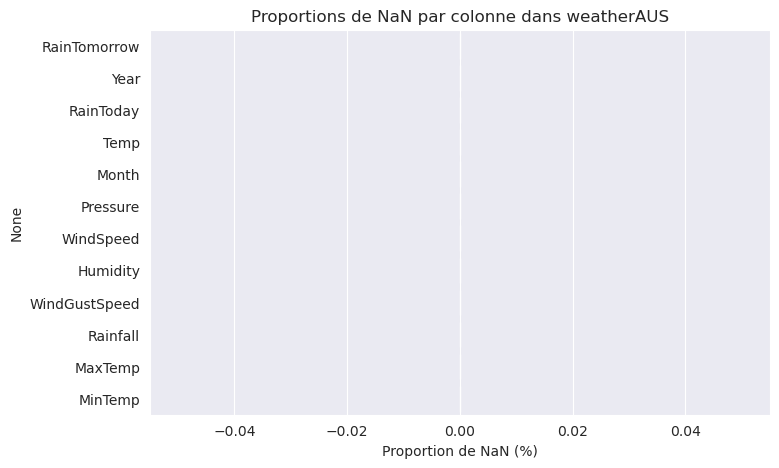

In [34]:
weatherAUS.dropna(inplace=True)
display_nan_proportion(dataframe=weatherAUS, dataframe_name="weatherAUS")

In [35]:
len(weatherAUS)

120960

In [36]:
weatherAUS['RainTomorrow'] = weatherAUS['RainTomorrow'].map({'Yes': 1, 'No': 0})
weatherAUS['RainToday'] = weatherAUS['RainToday'].map({'Yes': 1, 'No': 0})
weatherAUS

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,Humidity,WindSpeed,Pressure,Month,Temp,RainToday,Year,RainTomorrow
0,13.4,22.9,0.6,44.0,46.5,22.0,1007.40,12,19.35,0,2008,0
1,7.4,25.1,0.0,44.0,34.5,13.0,1009.20,12,20.75,0,2008,0
2,12.9,25.7,0.0,46.0,34.0,22.5,1008.15,12,22.10,0,2008,0
3,9.2,28.0,0.0,24.0,30.5,10.0,1015.20,12,22.30,0,2008,0
4,17.5,32.3,1.0,41.0,57.5,13.5,1008.40,12,23.75,0,2008,0
...,...,...,...,...,...,...,...,...,...,...,...,...
145454,3.5,21.8,0.0,31.0,43.0,14.0,1022.95,6,15.15,0,2017,0
145455,2.8,23.4,0.0,31.0,37.5,12.0,1022.45,6,16.25,0,2017,0
145456,3.6,25.3,0.0,22.0,38.5,11.0,1021.30,6,17.70,0,2017,0
145457,5.4,26.9,0.0,37.0,38.5,9.0,1018.90,6,19.30,0,2017,0


In [37]:
X = weatherAUS.drop(['RainTomorrow'], axis=1)
y = weatherAUS['RainTomorrow']

In [38]:
len(X), len(y)

(120960, 120960)

In [39]:
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l1, l2

In [14]:
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création du modèle
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compilation du modèle
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

# Entraînement du modèle
model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_test, y_test))

# Évaluation du modèle sur les données de test
loss, accuracy = model.evaluate(X_test, y_test)
print("Perte sur les données de test :", loss)
print("Précision sur les données de test :", accuracy)

Epoch 1/500


/home/wm18vw/Documents/EnvironnementsDevPython/miniconda3/envs/ML-env/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3024/3024 [==============================] - 7s 2ms/step - loss: 2.7448 - accuracy: 0.7671 - val_loss: 0.4870 - val_accuracy: 0.7800
Epoch 2/500
3024/3024 [==============================] - 6s 2ms/step - loss: 0.4906 - accuracy: 0.7855 - val_loss: 0.4454 - val_accuracy: 0.7833
Epoch 3/500
3024/3024 [==============================] - 7s 2ms/step - loss: 0.4672 - accuracy: 0.8020 - val_loss: 0.4381 - val_accuracy: 0.7872
Epoch 4/500
3024/3024 [==============================] - 7s 2ms/step - loss: 0.4650 - accuracy: 0.8043 - val_loss: 0.4095 - val_accuracy: 0.8128
Epoch 5/500
3024/3024 [==============================] - 7s 2ms/step - loss: 0.4645 - accuracy: 0.8033 - val_loss: 0.4229 - val_accuracy: 0.7937
Epoch 6/500
3024/3024 [==============================] - 7s 2ms/step - loss: 0.4635 - accuracy: 0.8039 - val_loss: 0.4215 - val_accuracy: 0.8009
Epoch 7/500
3024/3024 [==============================] - 6s 2ms/step - loss: 0.4619 - accuracy: 0.8050 - val_loss: 0.4272 - val_accuracy: 0.79

In [23]:
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création du modèle
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

# Définition des rappels ReduceLROnPlateau et EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compilation du modèle avec un learning rate initial
initial_learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Entraînement du modèle avec les rappels ReduceLROnPlateau et EarlyStopping
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[reduce_lr, early_stopping])

# Évaluation du modèle sur les données de test
loss, accuracy = model.evaluate(X_test, y_test)
print("Perte sur les données de test :", loss)
print("Précision sur les données de test :", accuracy)


Epoch 1/100
3024/3024 [==============================] - 9s 3ms/step - loss: 4.1335 - accuracy: 0.7599 - val_loss: 0.5308 - val_accuracy: 0.7783 - lr: 0.0010
Epoch 2/100
3024/3024 [==============================] - 8s 3ms/step - loss: 0.5321 - accuracy: 0.7812 - val_loss: 0.5291 - val_accuracy: 0.7783 - lr: 0.0010
Epoch 3/100
3024/3024 [==============================] - 8s 3ms/step - loss: 0.5276 - accuracy: 0.7815 - val_loss: 0.5291 - val_accuracy: 0.7783 - lr: 0.0010
Epoch 4/100
3024/3024 [==============================] - 8s 3ms/step - loss: 0.5259 - accuracy: 0.7817 - val_loss: 0.5292 - val_accuracy: 0.7783 - lr: 0.0010
Epoch 5/100
3024/3024 [==============================] - 8s 3ms/step - loss: 0.5252 - accuracy: 0.7817 - val_loss: 0.5291 - val_accuracy: 0.7783 - lr: 0.0010
Epoch 6/100
3024/3024 [==============================] - 8s 3ms/step - loss: 0.5251 - accuracy: 0.7817 - val_loss: 0.5291 - val_accuracy: 0.7783 - lr: 2.0000e-04
Epoch 7/100
756/756 [===========================

In [25]:
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création du modèle
model = Sequential()
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01), input_dim=X_train.shape[1]))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

# Définition des rappels ReduceLROnPlateau et EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compilation du modèle avec un learning rate initial
initial_learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Entraînement du modèle avec les rappels ReduceLROnPlateau et EarlyStopping
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[reduce_lr, early_stopping])

# Évaluation du modèle sur les données de test
loss, accuracy = model.evaluate(X_test, y_test)
print("Perte sur les données de test :", loss)
print("Précision sur les données de test :", accuracy)

Epoch 1/100
3024/3024 [==============================] - 9s 3ms/step - loss: 4.5531 - accuracy: 0.7636 - val_loss: 0.8245 - val_accuracy: 0.7783 - lr: 0.0010
Epoch 2/100
3024/3024 [==============================] - 8s 3ms/step - loss: 0.7401 - accuracy: 0.7814 - val_loss: 0.6582 - val_accuracy: 0.7783 - lr: 0.0010
Epoch 3/100
3024/3024 [==============================] - 8s 3ms/step - loss: 0.5981 - accuracy: 0.7815 - val_loss: 0.5568 - val_accuracy: 0.7783 - lr: 0.0010
Epoch 4/100
3024/3024 [==============================] - 7s 2ms/step - loss: 0.5371 - accuracy: 0.7816 - val_loss: 0.5322 - val_accuracy: 0.7783 - lr: 0.0010
Epoch 5/100
3024/3024 [==============================] - 8s 3ms/step - loss: 0.5258 - accuracy: 0.7818 - val_loss: 0.5293 - val_accuracy: 0.7783 - lr: 0.0010
Epoch 6/100
3024/3024 [==============================] - 8s 3ms/step - loss: 0.5247 - accuracy: 0.7818 - val_loss: 0.5292 - val_accuracy: 0.7783 - lr: 0.0010
Epoch 7/100
3024/3024 [=============================

In [26]:
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création du modèle
model = Sequential()
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01), input_dim=X_train.shape[1]))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

# Définition des rappels ReduceLROnPlateau et EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compilation du modèle avec un learning rate initial
initial_learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Entraînement du modèle avec les rappels ReduceLROnPlateau et EarlyStopping
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[reduce_lr, early_stopping])

# Évaluation du modèle sur les données de test
loss, accuracy = model.evaluate(X_test, y_test)
print("Perte sur les données de test :", loss)
print("Précision sur les données de test :", accuracy)

Epoch 1/100
3024/3024 [==============================] - 10s 3ms/step - loss: 2.8666 - accuracy: 0.7621 - val_loss: 1.0624 - val_accuracy: 0.7783 - lr: 0.0010
Epoch 2/100
3024/3024 [==============================] - 9s 3ms/step - loss: 0.8271 - accuracy: 0.7813 - val_loss: 0.6466 - val_accuracy: 0.7783 - lr: 0.0010
Epoch 3/100
3024/3024 [==============================] - 9s 3ms/step - loss: 0.5688 - accuracy: 0.7817 - val_loss: 0.5354 - val_accuracy: 0.7783 - lr: 0.0010
Epoch 4/100
3024/3024 [==============================] - 9s 3ms/step - loss: 0.5261 - accuracy: 0.7818 - val_loss: 0.5291 - val_accuracy: 0.7783 - lr: 0.0010
Epoch 5/100
3024/3024 [==============================] - 8s 3ms/step - loss: 0.5247 - accuracy: 0.7818 - val_loss: 0.5291 - val_accuracy: 0.7783 - lr: 0.0010
Epoch 6/100
3024/3024 [==============================] - 9s 3ms/step - loss: 0.5247 - accuracy: 0.7818 - val_loss: 0.5291 - val_accuracy: 0.7783 - lr: 0.0010
Epoch 7/100
3024/3024 [============================

In [27]:
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création du modèle
model = Sequential()
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01), input_dim=X_train.shape[1]))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

# Définition des rappels ReduceLROnPlateau et EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compilation du modèle avec un learning rate initial
initial_learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Entraînement du modèle avec les rappels ReduceLROnPlateau et EarlyStopping
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[reduce_lr, early_stopping])

# Évaluation du modèle sur les données de test
loss, accuracy = model.evaluate(X_test, y_test)
print("Perte sur les données de test :", loss)
print("Précision sur les données de test :", accuracy)

Epoch 1/100
3024/3024 [==============================] - 10s 3ms/step - loss: 3.8101 - accuracy: 0.7658 - val_loss: 1.0510 - val_accuracy: 0.7783 - lr: 0.0010
Epoch 2/100
3024/3024 [==============================] - 9s 3ms/step - loss: 0.8871 - accuracy: 0.7813 - val_loss: 0.7283 - val_accuracy: 0.7783 - lr: 0.0010
Epoch 3/100
3024/3024 [==============================] - 9s 3ms/step - loss: 0.6229 - accuracy: 0.7816 - val_loss: 0.5572 - val_accuracy: 0.7783 - lr: 0.0010
Epoch 4/100
3024/3024 [==============================] - 9s 3ms/step - loss: 0.5330 - accuracy: 0.7818 - val_loss: 0.5297 - val_accuracy: 0.7783 - lr: 0.0010
Epoch 5/100
3024/3024 [==============================] - 9s 3ms/step - loss: 0.5248 - accuracy: 0.7818 - val_loss: 0.5292 - val_accuracy: 0.7783 - lr: 0.0010
Epoch 6/100
3024/3024 [==============================] - 9s 3ms/step - loss: 0.5247 - accuracy: 0.7818 - val_loss: 0.5291 - val_accuracy: 0.7783 - lr: 0.0010
Epoch 7/100
3024/3024 [============================

In [41]:
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création du modèle
model = Sequential()
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01), input_dim=X_train.shape[1]))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

# Définition des rappels ReduceLROnPlateau et EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compilation du modèle avec un learning rate initial
initial_learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Entraînement du modèle avec les rappels ReduceLROnPlateau et EarlyStopping
history = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_test, y_test), callbacks=[reduce_lr, early_stopping])

# Évaluation du modèle sur les données de test
loss, accuracy = model.evaluate(X_test, y_test)
print("Perte sur les données de test :", loss)
print("Précision sur les données de test :", accuracy)

Epoch 1/100
756/756 [==============================] - 4s 3ms/step - loss: 4.8078 - accuracy: 0.7420 - val_loss: 1.1176 - val_accuracy: 0.7783 - lr: 0.0010
Epoch 2/100
756/756 [==============================] - 2s 3ms/step - loss: 1.0594 - accuracy: 0.7800 - val_loss: 0.9639 - val_accuracy: 0.7783 - lr: 0.0010
Epoch 3/100
756/756 [==============================] - 2s 3ms/step - loss: 0.9112 - accuracy: 0.7811 - val_loss: 0.8545 - val_accuracy: 0.7783 - lr: 0.0010
Epoch 4/100
756/756 [==============================] - 2s 3ms/step - loss: 0.8057 - accuracy: 0.7813 - val_loss: 0.7628 - val_accuracy: 0.7783 - lr: 0.0010
Epoch 5/100
756/756 [==============================] - 2s 3ms/step - loss: 0.7238 - accuracy: 0.7814 - val_loss: 0.6910 - val_accuracy: 0.7783 - lr: 0.0010
Epoch 6/100
756/756 [==============================] - 2s 3ms/step - loss: 0.6581 - accuracy: 0.7816 - val_loss: 0.6347 - val_accuracy: 0.7783 - lr: 0.0010
Epoch 7/100
756/756 [==============================] - 2s 3ms/st